# **ML Based Curvature Estimation Within a VOF Framework - FeedForwardNN**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import All Needed Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import TensorDataset, DataLoader

Loading Data (Already Generated with GenerateData File)

In [ ]:
# Data Name and Pth
filePath = '/content/drive/MyDrive/ML-BasedCurvatureEstimation/'
fileName = 'Ds2-5x5.xlsx'

# Load Data
dataset = pd.read_excel(filePath + fileName, skiprows=1)

datasetSize = dataset.shape[0]
stencilSize = int(np.sqrt(dataset.shape[1]-1))
flatStencilSize = stencilSize*stencilSize
outputSize = 1

print('Number of Examples:', datasetSize)
print('Stencil Size:', stencilSize,"x",stencilSize)

x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

x_tensor = torch.tensor(x.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)


Number of Examples: 49999
Stencil Size: 5 x 5


# Define NN Architecture

In [ ]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(flatStencilSize, 80)  # First layer takes 9 (if 3x3 stencil is used) inputs and has 80 neurons
        self.fc2 = nn.Linear(80, 80) # Second hidden layer with 80 neurons
        self.fc3 = nn.Linear(80, 80) # Third hidden layer with 80 neurons
        self.fc4 = nn.Linear(80, outputSize)  # Output layer with 1 output (curvature)

        # # Initialize weights using Xavier uniform
        # init.xavier_uniform_(self.fc1.weight)
        # init.xavier_uniform_(self.fc2.weight)
        # init.xavier_uniform_(self.fc3.weight)
        # init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        # Use the tanh activation function between layers
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()


In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
##scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

Epochs = 2000
batchSize = 128

trainSetSize = 0.7
valSetSize = 0.15
testSetSize = 1- trainSetSize - valSetSize

In [ ]:
# Split the data into training and test sets
train_size = int(trainSetSize * len(x))
validate_size = int(valSetSize * len(x))
test_size = len(x) - train_size - validate_size

x_train, x_validate, x_test = torch.split(x_tensor, [train_size, validate_size, test_size])
y_train, y_validate, y_test = torch.split(y_tensor, [train_size, validate_size, test_size])

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)


In [ ]:
# Train step function
def train_step(model, criterion, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    y = y.view(-1, 1)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
# Validation step function
def validation_step(model, criterion, x, y):
    model.eval()
    with torch.no_grad():
        output = model(x)
        y = y.view(-1, 1)
        loss = criterion(output, y)
    return loss.item()


In [ ]:
# Training and evaluation loop with loss tracking
def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            train_loss += train_step(model, criterion, optimizer, x_batch, y_batch)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        for x_batch, y_batch in test_loader:
            val_loss += validation_step(model, criterion, x_batch, y_batch)
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        # Update the learning rate
        ##scheduler.step()

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')

    return train_losses, val_losses


# Train Model

In [ ]:
# Run the training and evaluation
train_losses, val_losses = train_and_evaluate(net, criterion, optimizer, train_loader, test_loader, epochs=Epochs)


Epoch [0/2000] Train Loss: 0.00286559, Validation Loss: 0.00220797
Epoch [100/2000] Train Loss: 0.00003772, Validation Loss: 0.00004988
Epoch [200/2000] Train Loss: 0.00002377, Validation Loss: 0.00002521
Epoch [300/2000] Train Loss: 0.00001684, Validation Loss: 0.00001765
Epoch [400/2000] Train Loss: 0.00001387, Validation Loss: 0.00001382
Epoch [500/2000] Train Loss: 0.00001058, Validation Loss: 0.00001156
Epoch [600/2000] Train Loss: 0.00001217, Validation Loss: 0.00000908
Epoch [700/2000] Train Loss: 0.00000974, Validation Loss: 0.00001005
Epoch [800/2000] Train Loss: 0.00000752, Validation Loss: 0.00000706
Epoch [900/2000] Train Loss: 0.00000682, Validation Loss: 0.00001273
Epoch [1000/2000] Train Loss: 0.00000527, Validation Loss: 0.00000567
Epoch [1100/2000] Train Loss: 0.00000606, Validation Loss: 0.00001160
Epoch [1200/2000] Train Loss: 0.00000495, Validation Loss: 0.00000692
Epoch [1300/2000] Train Loss: 0.00000523, Validation Loss: 0.00000566
Epoch [1400/2000] Train Loss: 0.

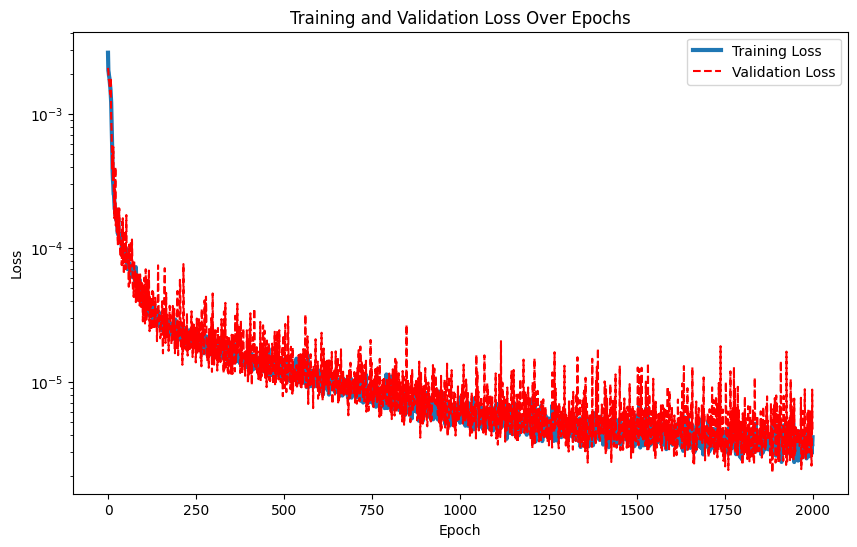

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=3, label='Training Loss')
plt.plot(val_losses,"r--", label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Test Model

In [ ]:
# After training
net.eval()
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
predictions = net(x_test_tensor).detach().numpy()

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 4.1745252019609325e-06


<ipython-input-14-bbd5eb7ffd00>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


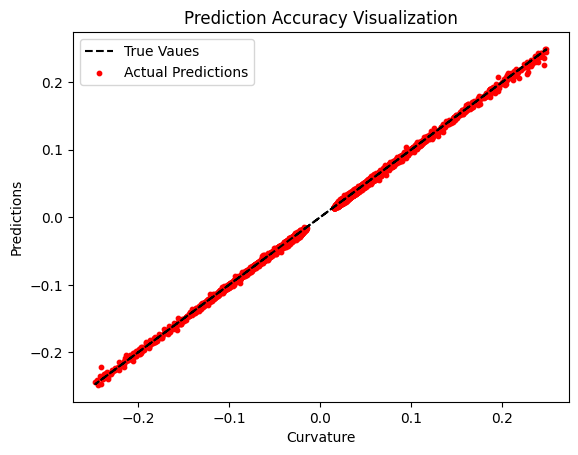

In [ ]:
# Create a figure and an axes.
fig, ax = plt.subplots()

# Plot the y_test vs y_test line (perfect prediction reference)
ax.plot(y_test, y_test, 'k--', label='True Vaues')  # 'k--' means black dashed line

# Scatter plot of y_test vs predictions
ax.scatter(y_test, predictions, color='red', label='Actual Predictions',s=10)

# Set labels and title
ax.set_xlabel('Curvature')
ax.set_ylabel('Predictions')
ax.set_title('Prediction Accuracy Visualization')
ax.legend()

# Show the plot
plt.show()

# Save Model

In [ ]:
# Save the entire model
#torch.save(net, 'full_model.pth')


In [ ]:
# Load the entire model
#net = torch.load('full_model.pth')
#net.eval()  # Set the model to evaluation mode
